# 1) Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import silhouette_visualizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

warnings.filterwarnings("ignore")

# 2) Coleta dos Dados

In [26]:
df = pd.read_csv(r'../Dados/Tabela_final/tabela_final.csv')
df

,IBGE7,UF,NOME,LATITUDE,LONGITUDE,DIST_EF_PUB,DIST_EM_PUB,IDEB_AI,IDEB_AF,DOCSUP_EF_PUB,...,T_ANALF18M,T_ANALF25A29,T_ANALF25M,RDPC,QUAL_MED_AGUA,TRANSPORT_COST,TOT_ESC_POR_POP,TOT_MAT_POR_POP,DIST_CAPITAL,CAPITAL_PROX
0,2700300,AL,ARAPIRACA,-9.75487,-36.6615,28.884,43.100,4.580,3.624,54.40,...,24.10,11.76,28.61,423.28,62.486900,24042.166072,0.000433,0.245423,102.025981,MACEIO
1,2700706,AL,BATALHA,-9.67420,-37.1330,31.100,35.892,4.544,3.632,12.62,...,33.44,20.53,40.54,265.62,62.486900,24257.110578,0.001200,0.384829,137.500525,ARACAJU
2,2700904,AL,BELO MONTE,-9.82272,-37.2770,36.412,54.792,3.928,3.044,27.12,...,41.81,30.29,49.99,187.77,52.964055,24226.863743,0.002235,0.298063,122.950205,ARACAJU
3,2701209,AL,CACIMBINHAS,-9.40121,-36.9911,38.284,40.720,4.164,3.324,49.04,...,43.81,30.14,51.12,259.72,62.486900,24358.206538,0.001102,0.419781,140.854338,MACEIO
4,2701605,AL,CANAPI,-9.11932,-37.5967,31.024,38.636,4.584,3.580,20.84,...,44.16,28.31,51.97,183.83,74.933851,24734.221802,0.002032,0.366838,207.272744,ARACAJU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2806008,SE,RIBEIROPOLIS,-10.53570,-37.4380,35.080,41.796,4.032,3.472,64.68,...,30.60,11.60,36.26,357.17,65.680219,23891.778664,0.000692,0.211261,57.971219,ARACAJU
1257,2807006,SE,SAO MIGUEL DO ALEIXO,-10.38470,-37.3836,33.148,47.912,3.940,3.116,62.08,...,37.03,18.32,44.72,279.25,65.680219,23954.902605,0.002280,0.196098,67.763439,ARACAJU
1258,2807105,SE,SIMAO DIAS,-10.73870,-37.8097,38.340,45.756,4.200,3.364,61.38,...,28.90,14.39,34.16,293.99,65.680219,23918.838452,0.001108,0.254938,83.224418,ARACAJU
1259,2807303,SE,TELHA,-10.20640,-36.8818,31.636,47.600,4.384,3.520,45.66,...,29.62,14.00,35.41,268.17,62.486900,23869.921712,0.001539,0.222838,80.736011,ARACAJU


# 2) Análise Exploratória

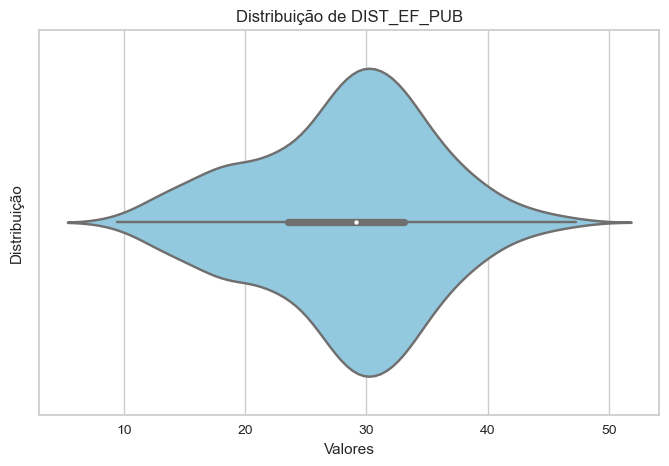

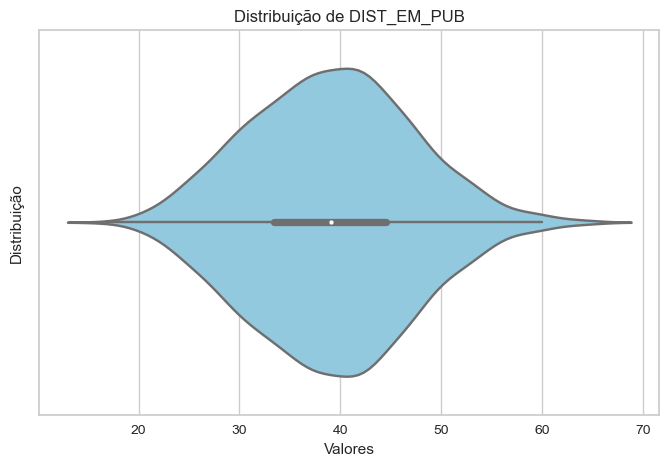

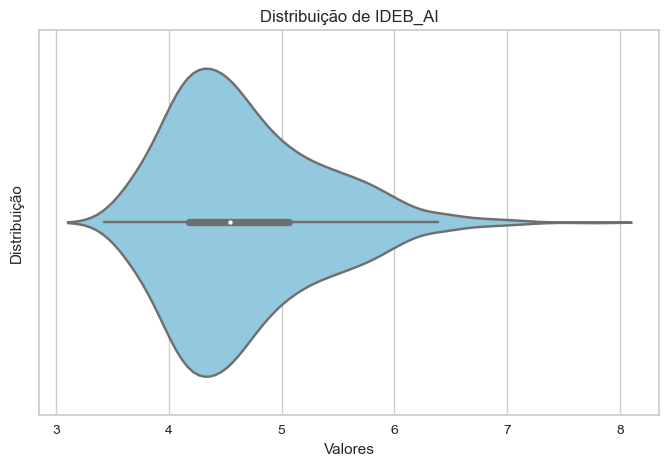

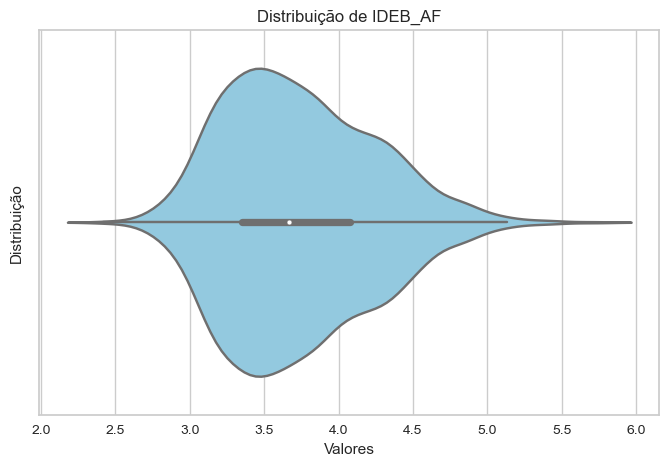

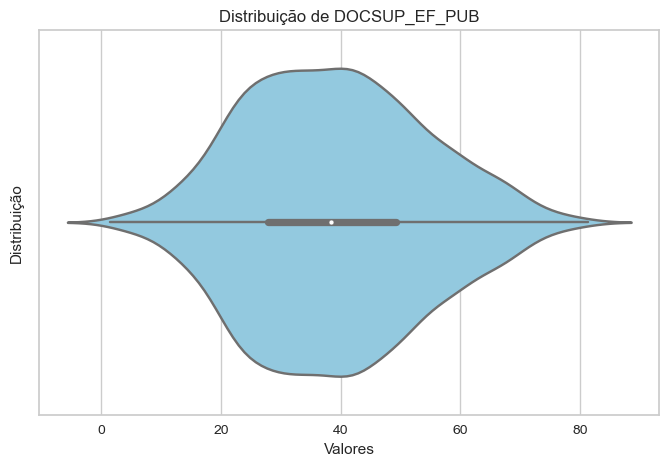

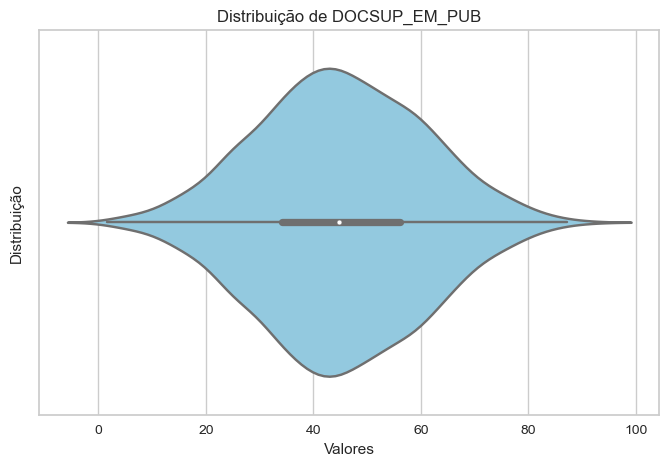

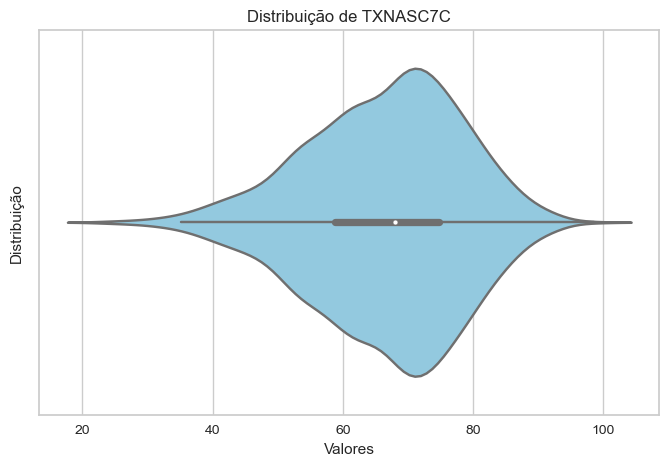

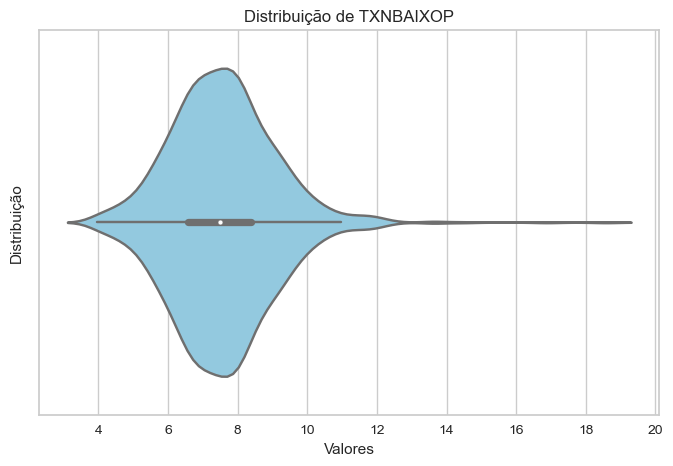

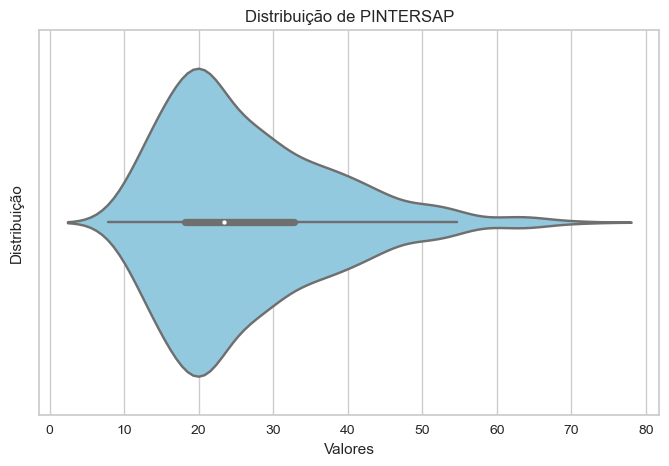

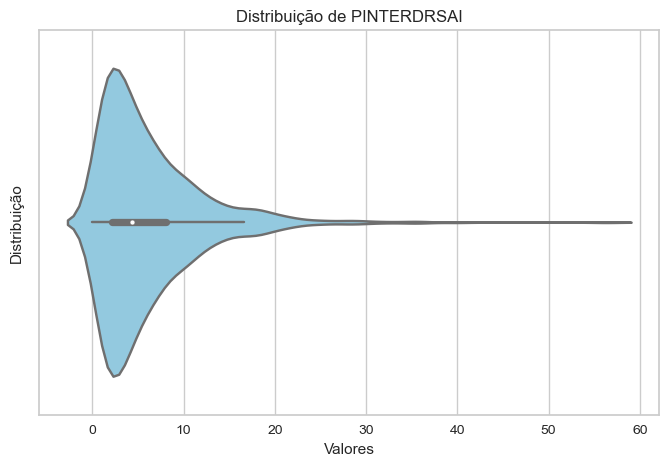

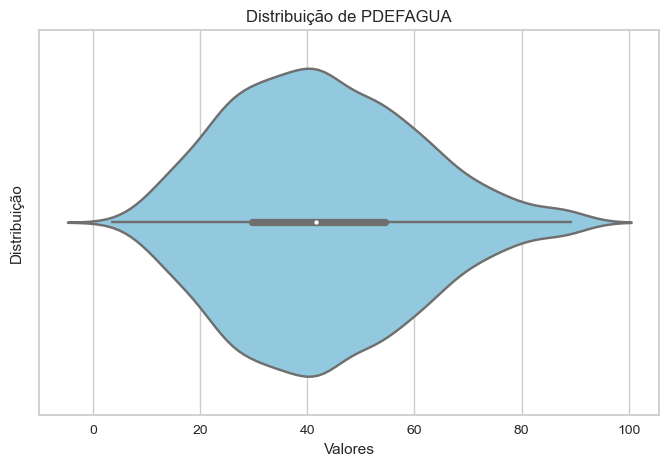

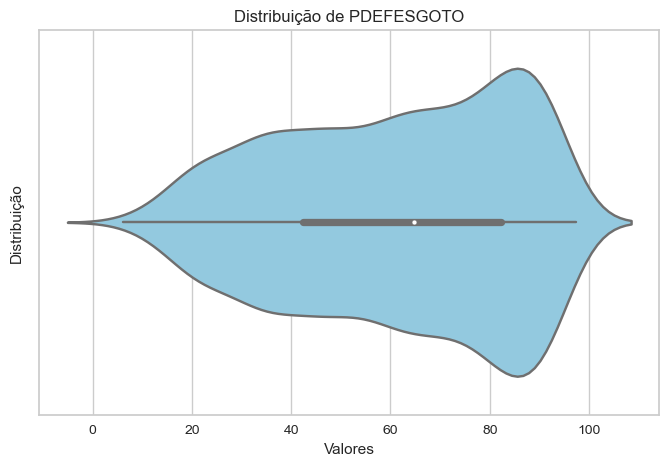

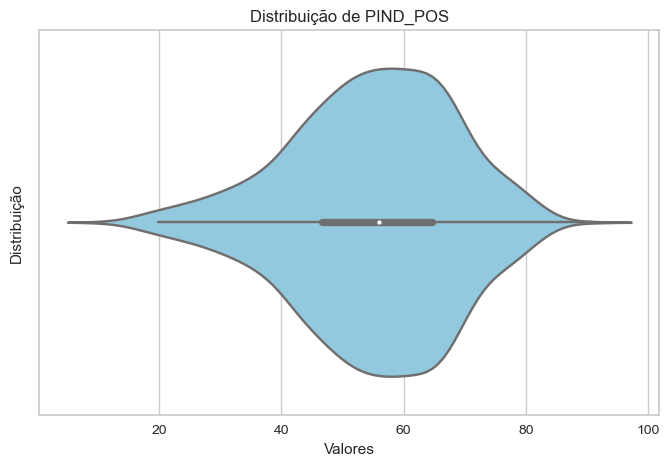

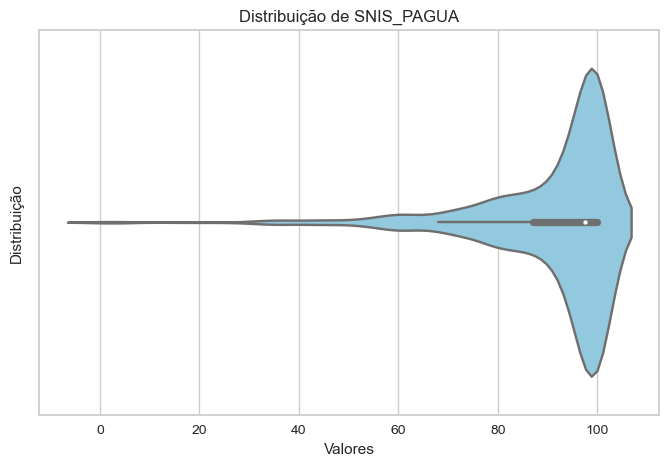

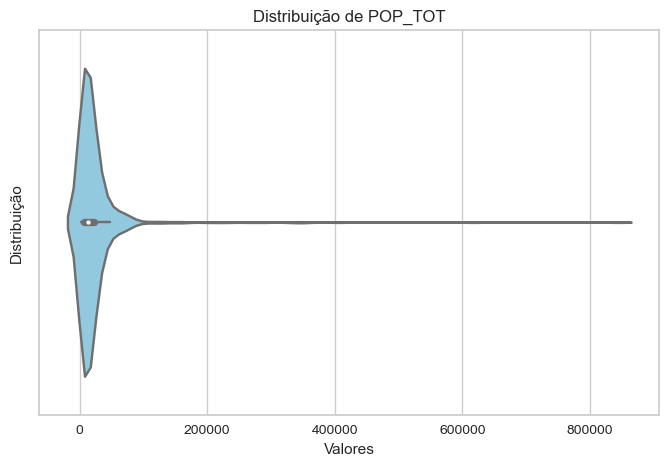

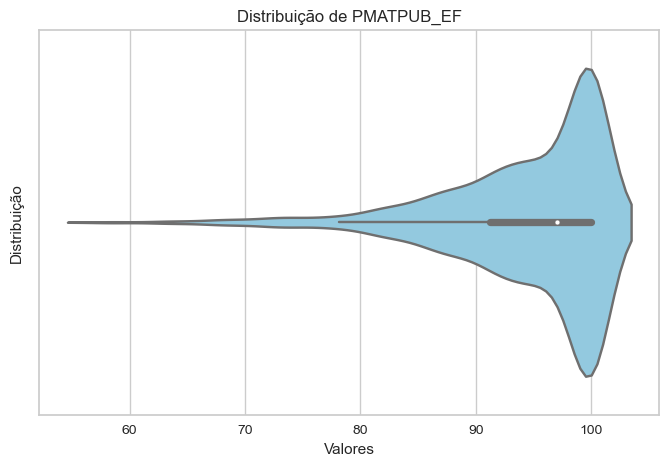

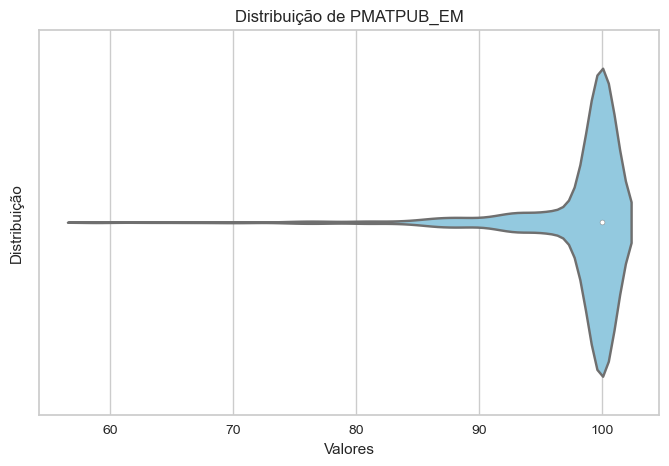

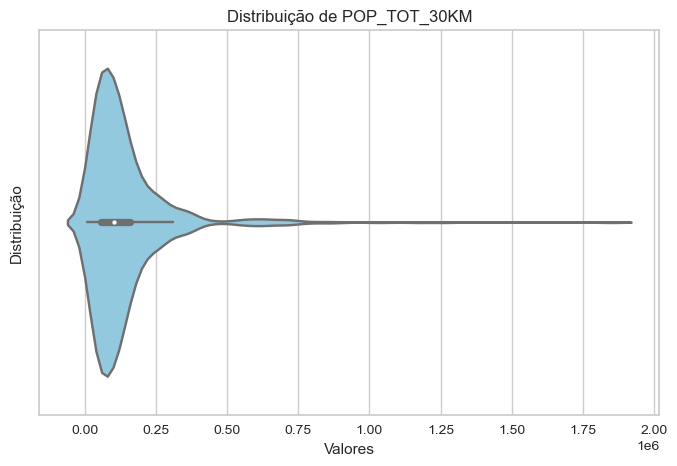

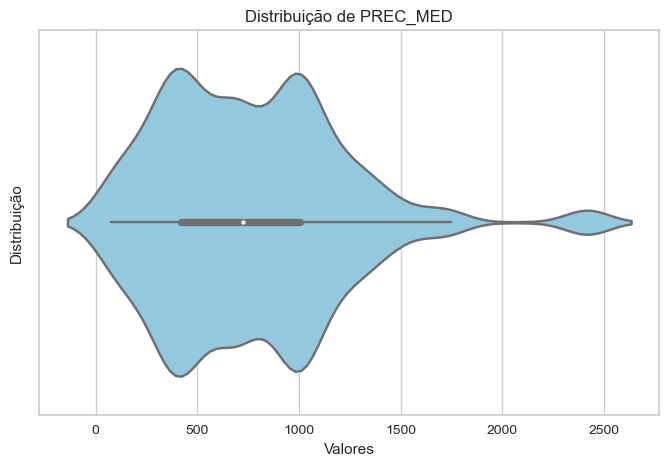

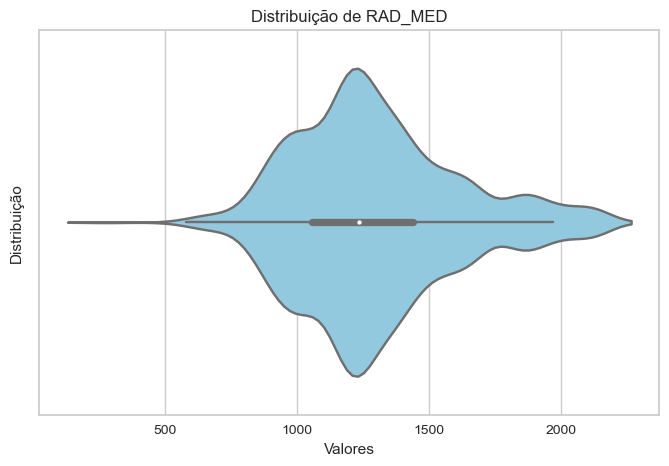

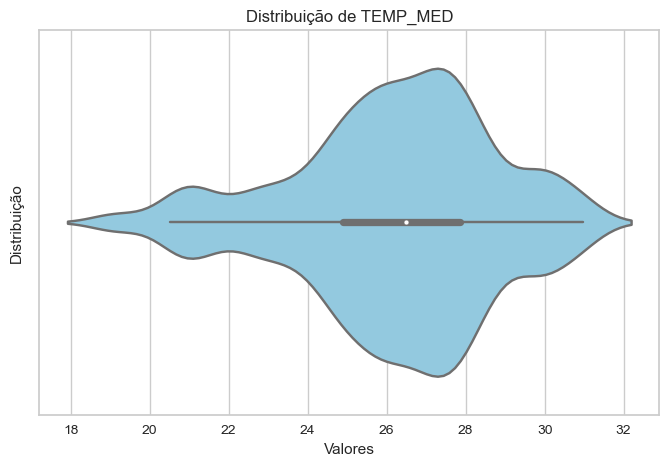

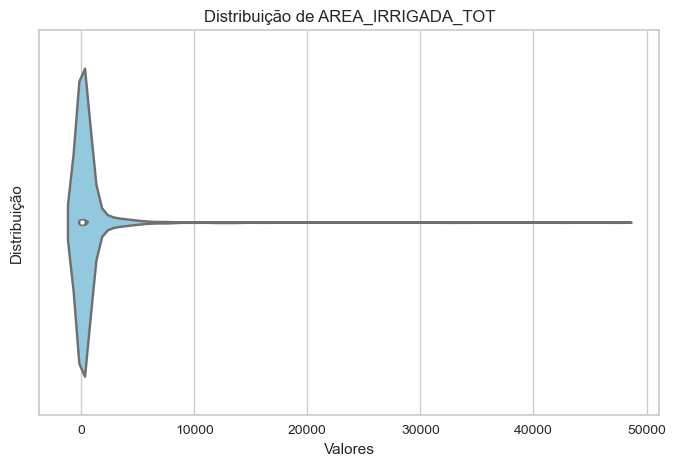

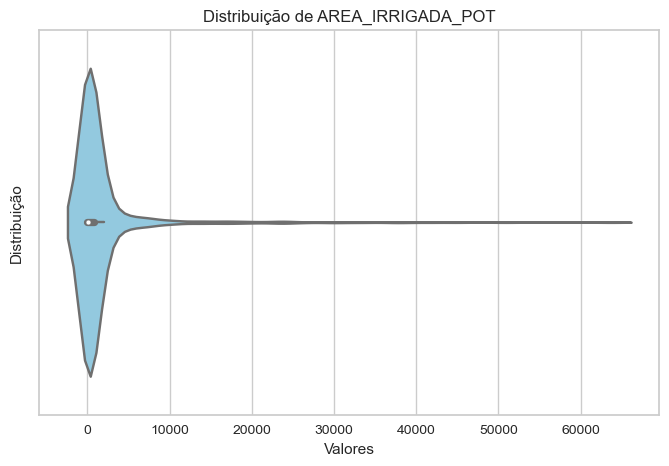

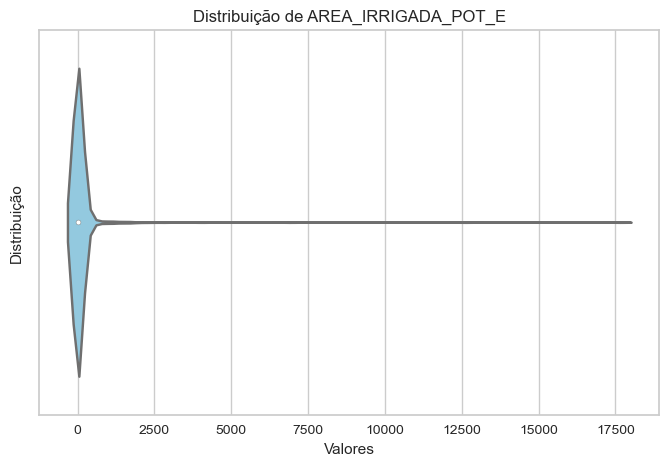

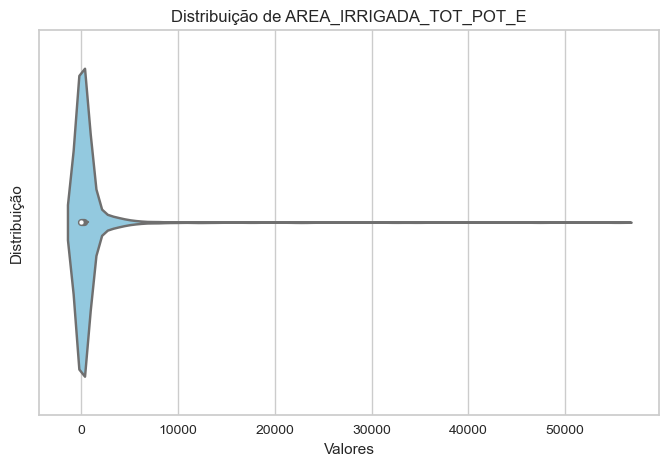

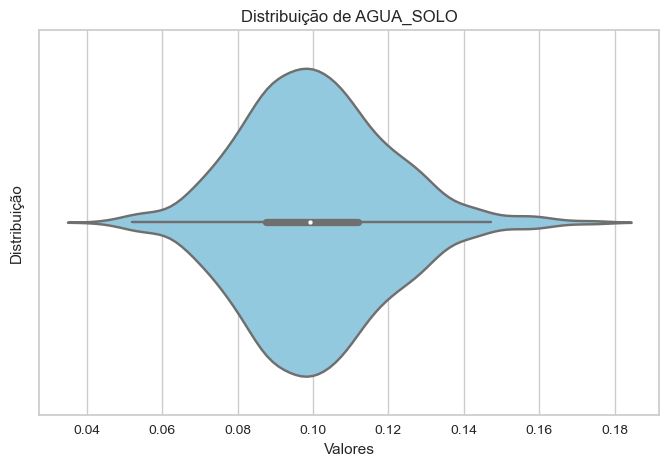

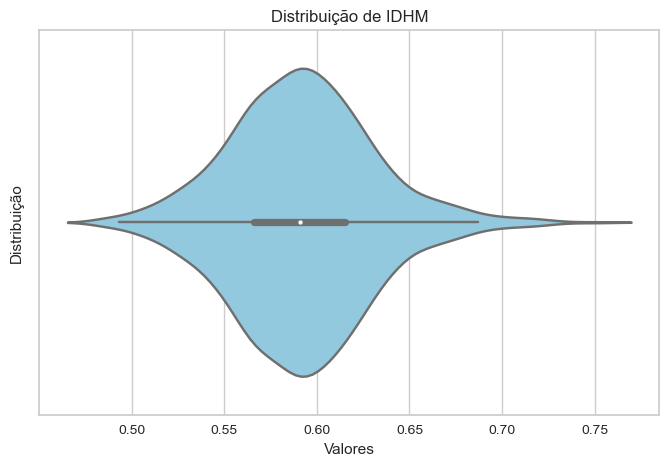

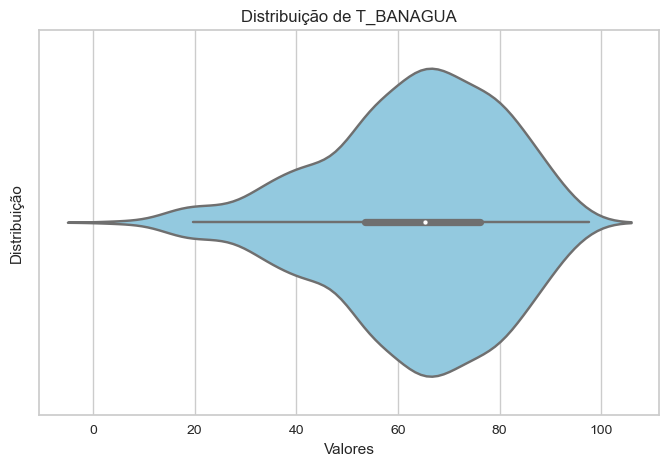

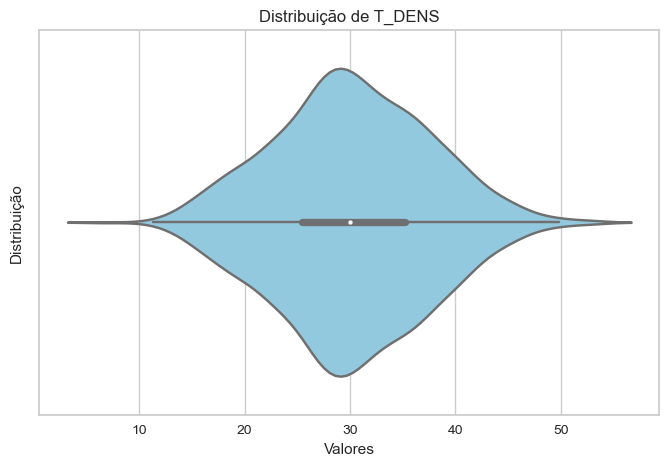

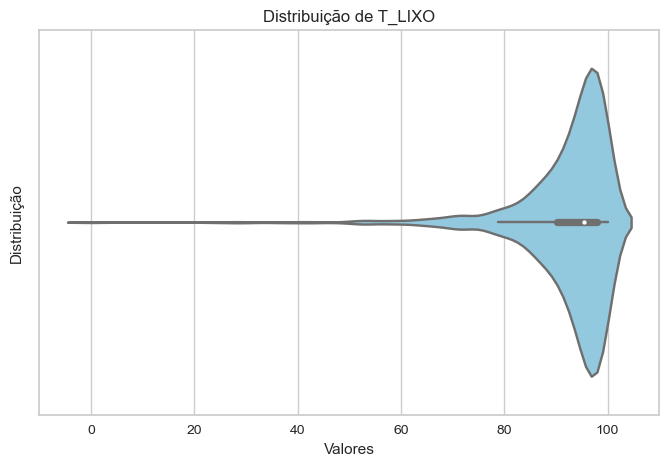

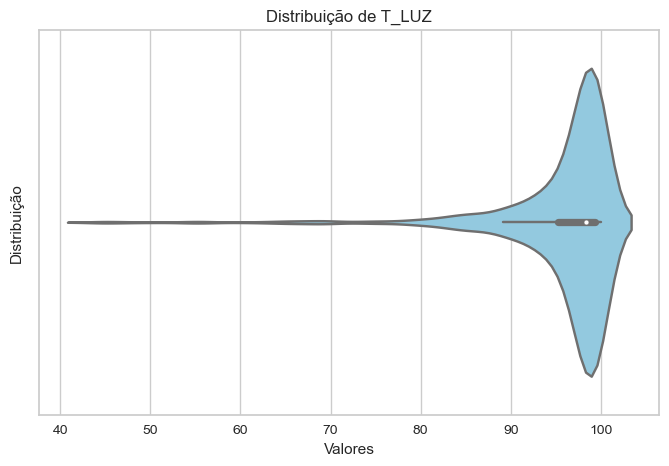

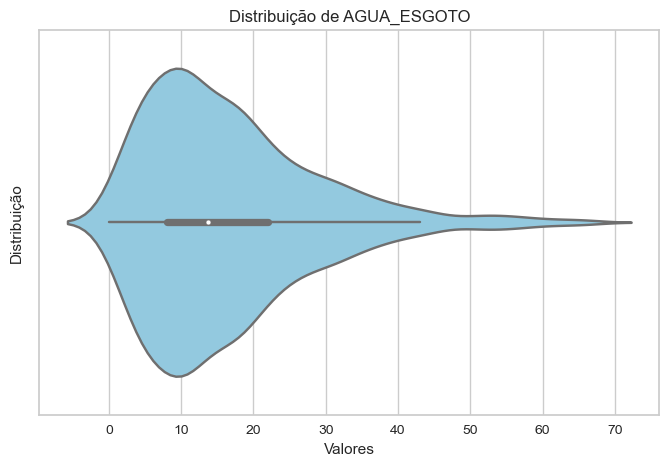

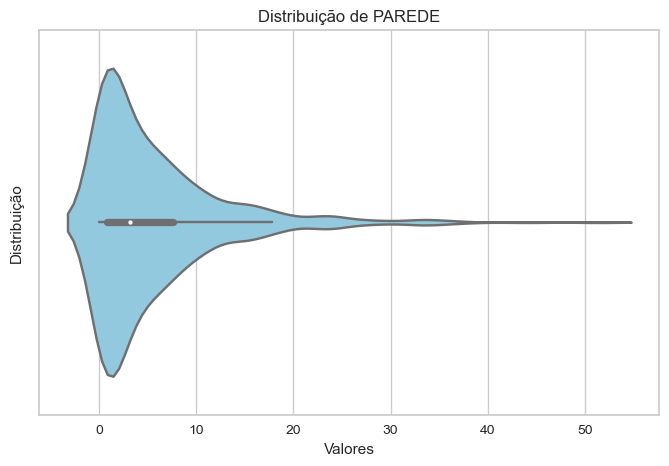

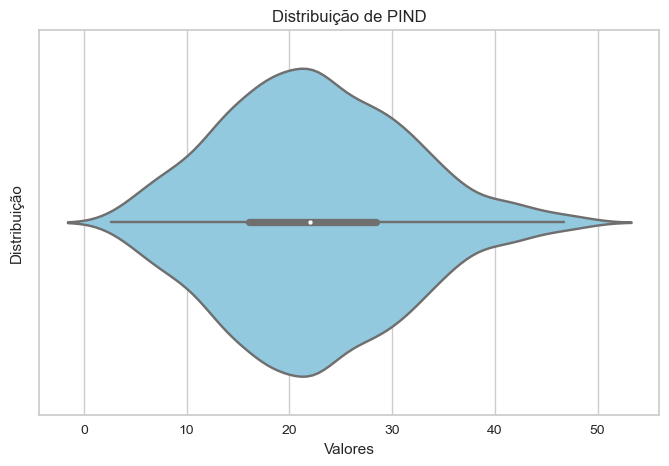

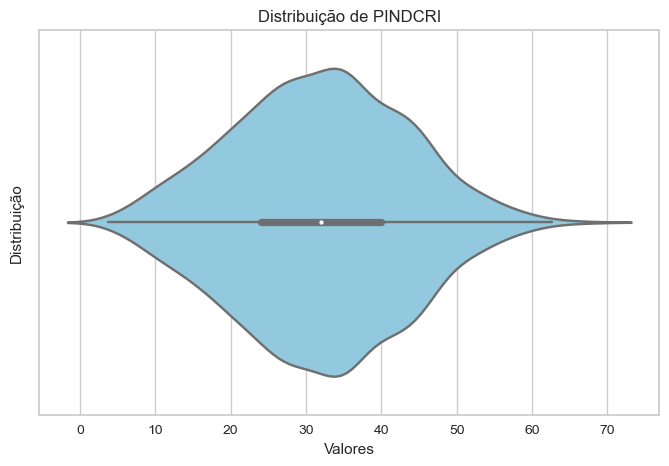

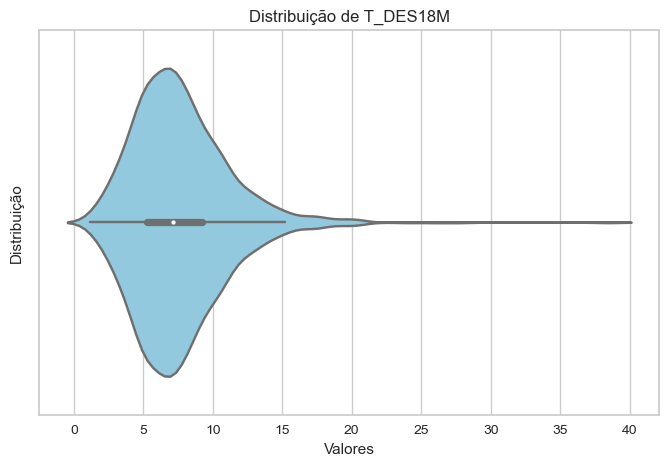

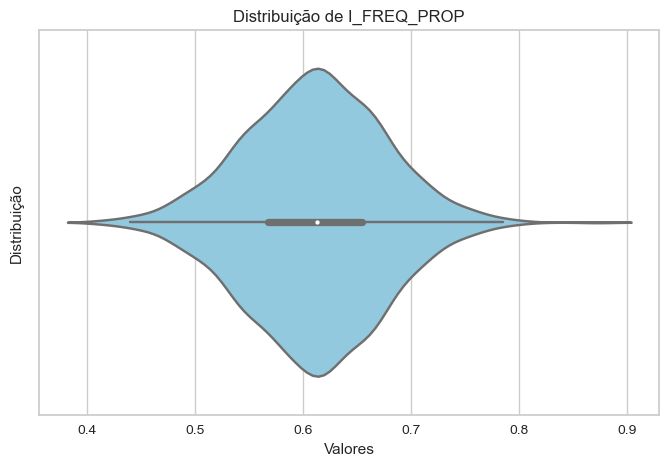

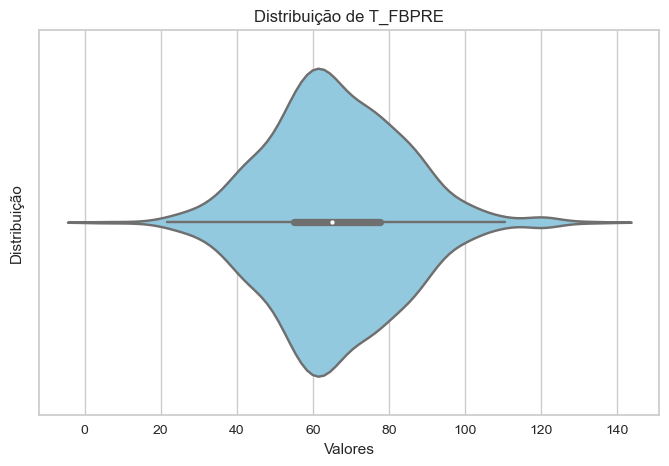

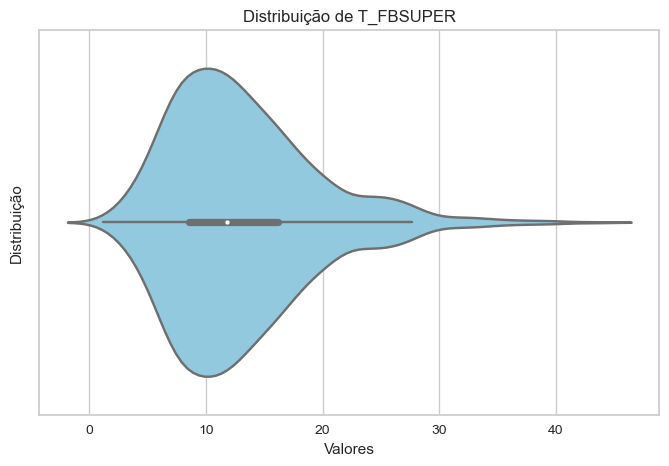

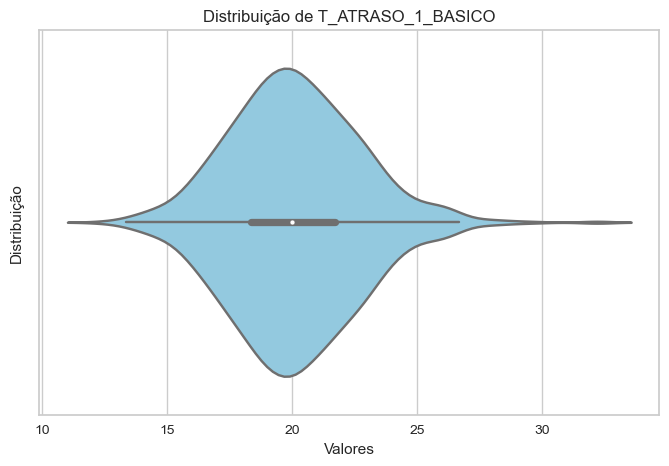

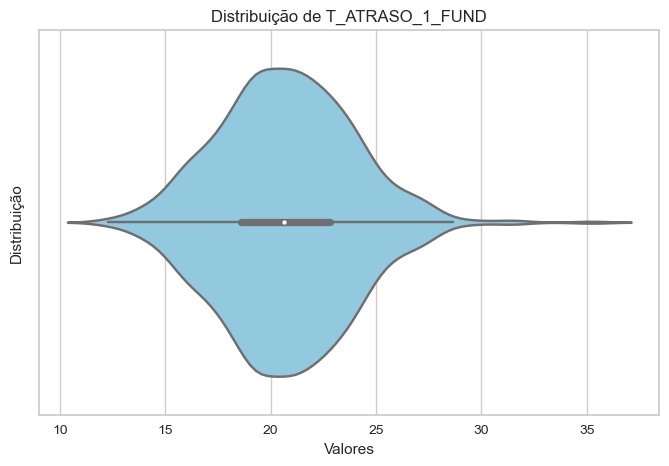

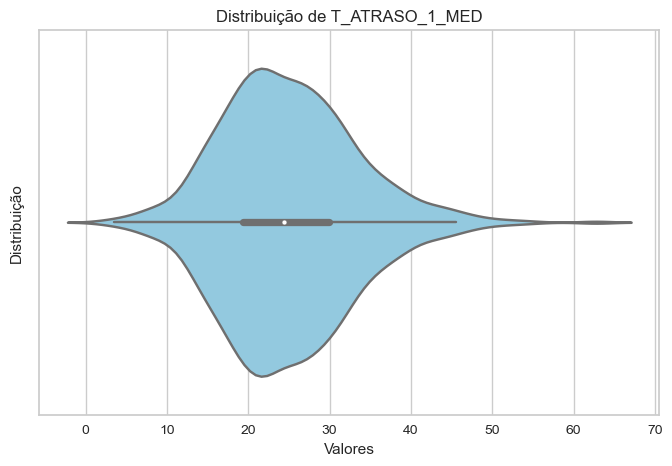

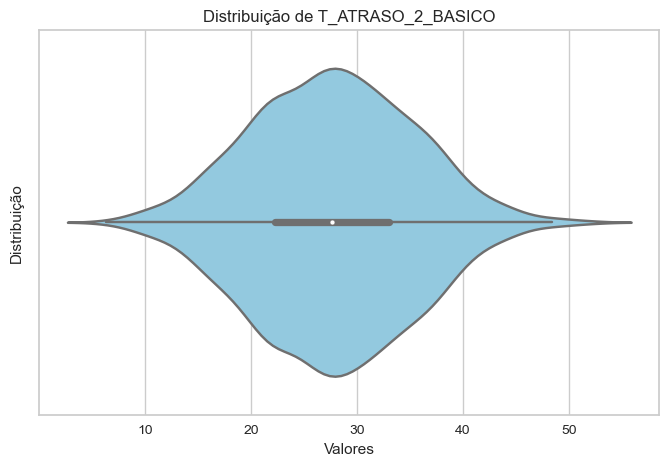

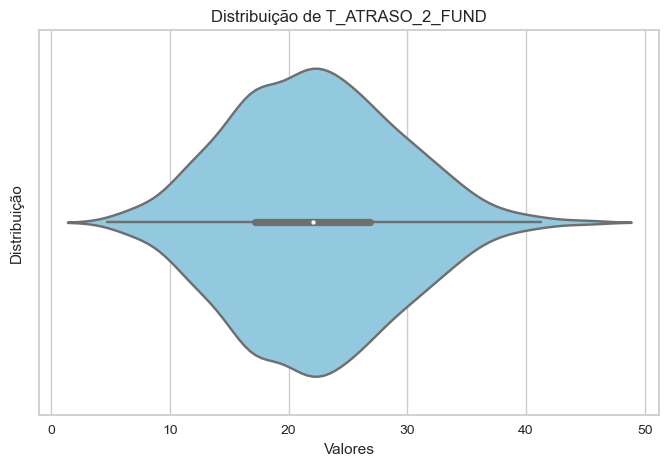

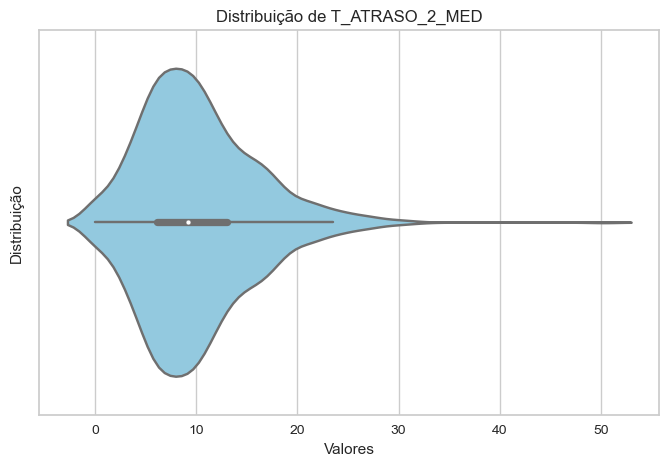

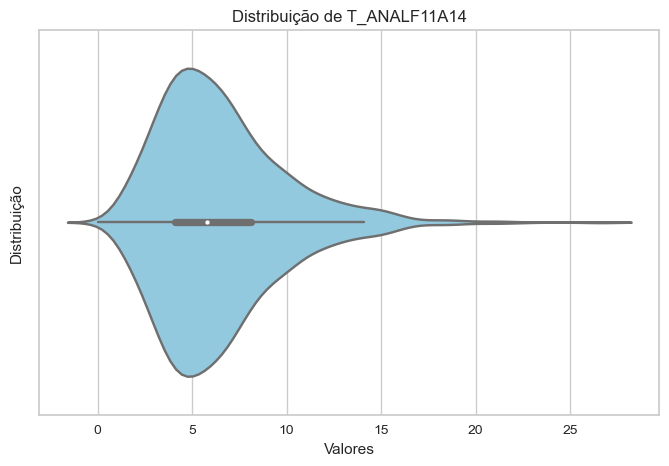

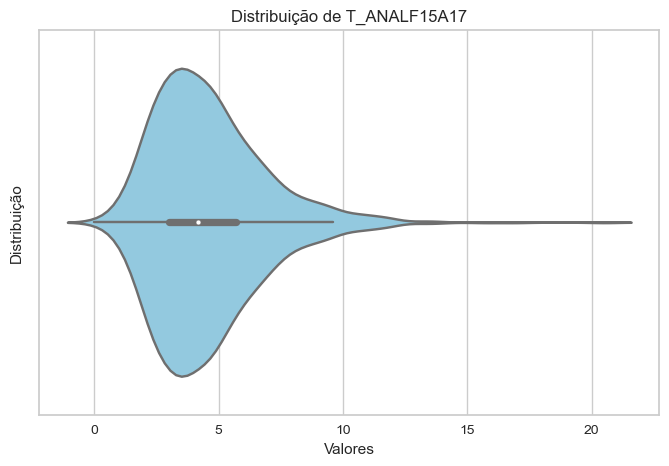

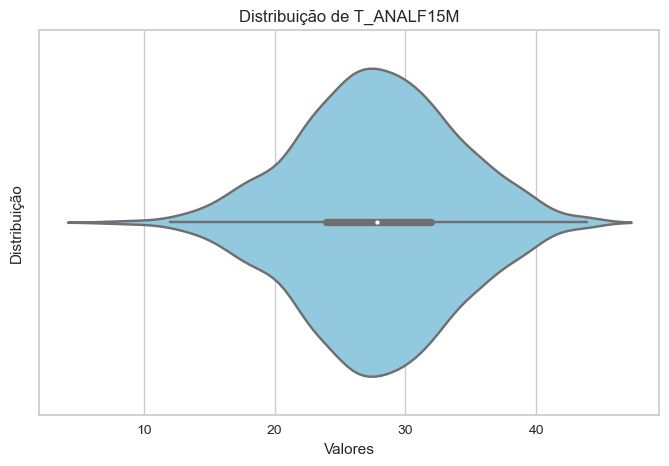

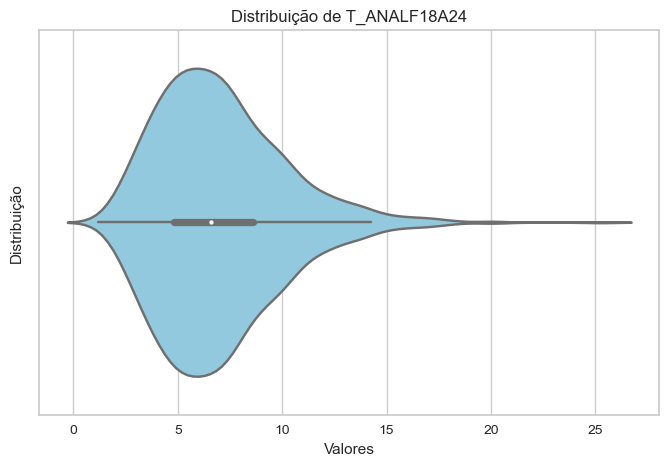

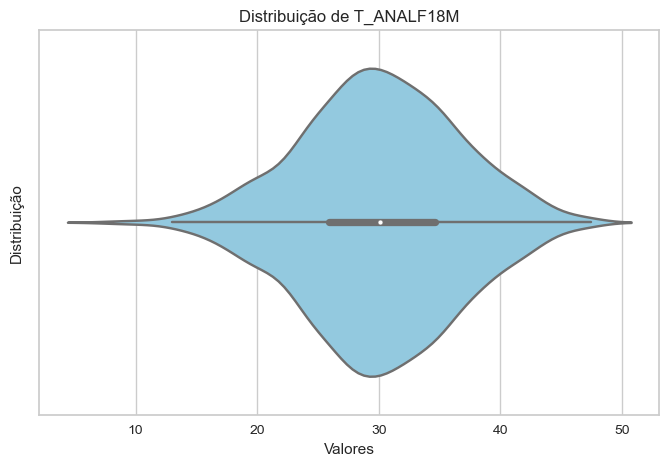

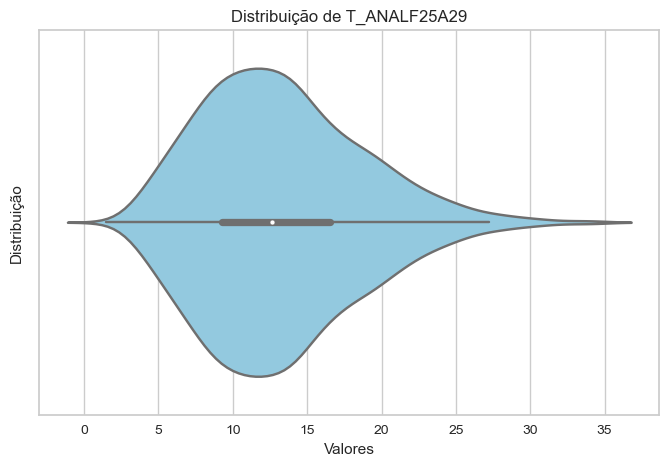

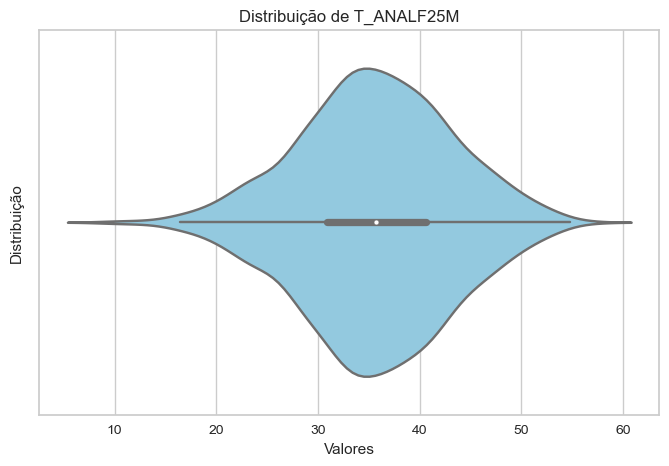

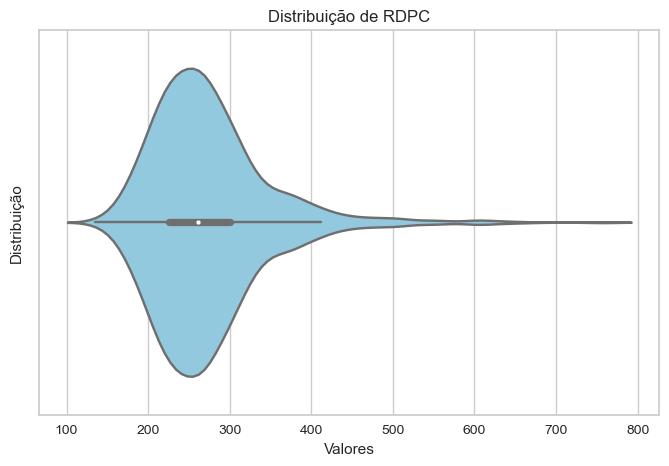

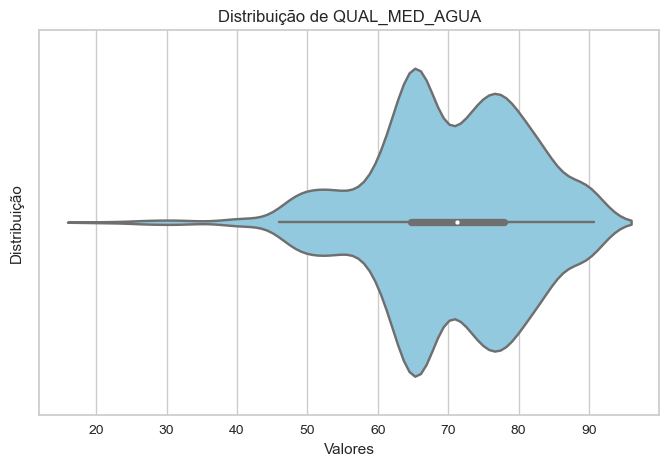

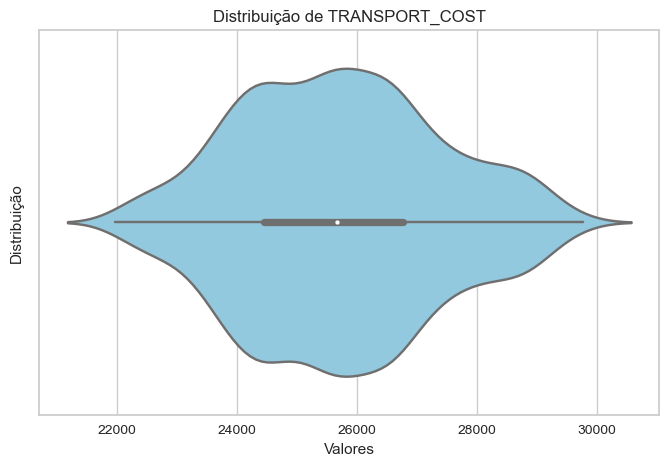

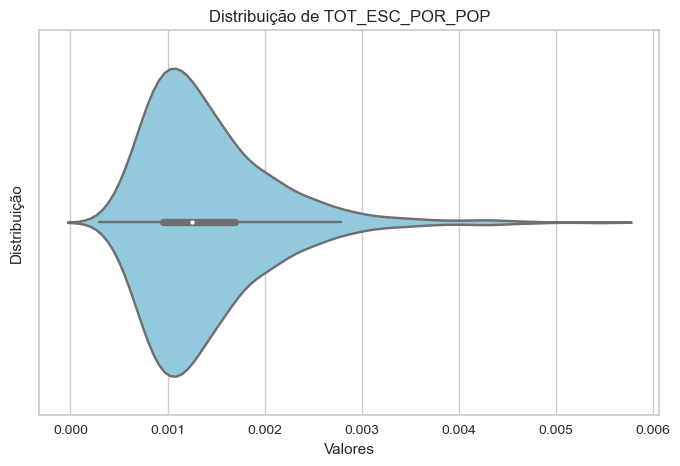

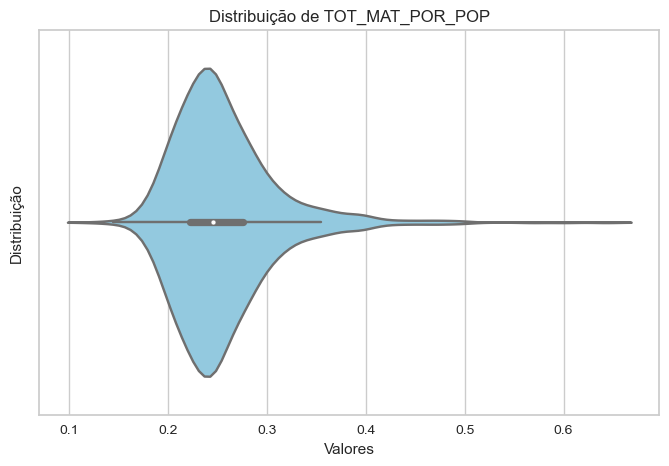

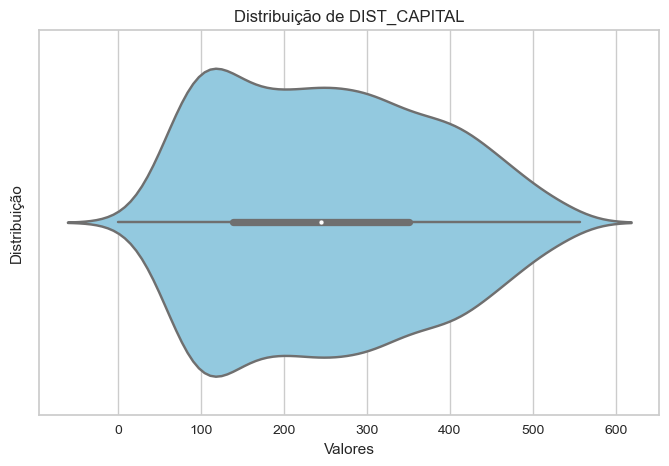

In [27]:
columns = [coluna for coluna in df.columns if (df[coluna].dtype == 'float64')&(coluna not in ['LATITUDE', 'LONGITUDE'])]

for column in columns:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=df[column], color='skyblue')
        
    plt.xlabel('Valores') 
    plt.ylabel('Distribuição')
    plt.title(f'Distribuição de {column}')
    plt.show()

# 3) Redução da dimensinalidade e análise de cluster

## 3.1) Pré-processamento

In [28]:
df_numeric_features = df[columns].copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_features)

## 3.2) Aplicação do PCA

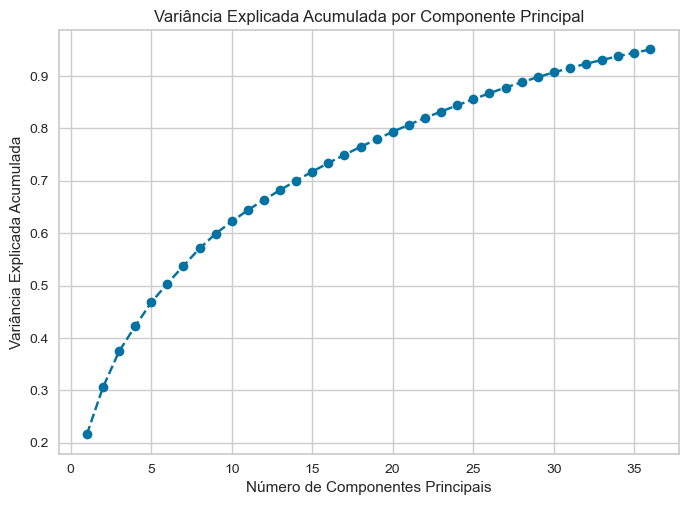

In [29]:
pca = PCA(n_components = 0.95)
df_reducted = pca.fit_transform(df_scaled)

variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.3) Análise de cluster

In [30]:
tsne = TSNE(n_components=2, random_state=42)
df_components = tsne.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

def plot(df, df_components, clusters):
    df = pd.concat([df, df_components], axis = 1)
    df['CLUSTER'] = clusters

    actual_cities = df[
        [
            'NOME', 
            'COMPONENT1', 
            'COMPONENT2', 
            'CLUSTER'
        ]
    ].loc[
        df['NOME'].isin(
            [
                'MAURITI', 
                'SAO JOSE DA TAPERA', 
                'BUIQUE', 
                'INAJA'
            ]
        )
    ]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        hue='CLUSTER', 
        palette='Set2'
    )
    sns.scatterplot(
        data=actual_cities, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        marker = 'X', 
        color='black', 
        s=100, 
        label='Cidades atuais'
    )
    for i, row in actual_cities.iterrows():
        plt.text(row['COMPONENT1'] + 0.1, row['COMPONENT2'], row['NOME'], fontsize=12)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Visualização dos Clusters')
    plt.legend(title='Cluster', loc='upper right')
    plt.grid(True)
    plt.show()

### 3.3.1) Hierarchical Clustering

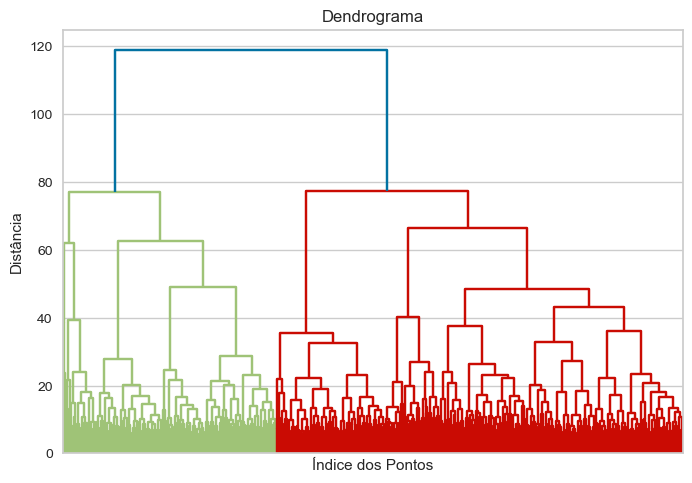

In [8]:
linkage_matrix = linkage(df_reducted, method='ward')

plt.figure()
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xticks([])
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
plt.show()

Silhouette Score:  0.1049
Davies-Bouldin Score:  2.6923
Calinski-Harabasz Index:  144.6481


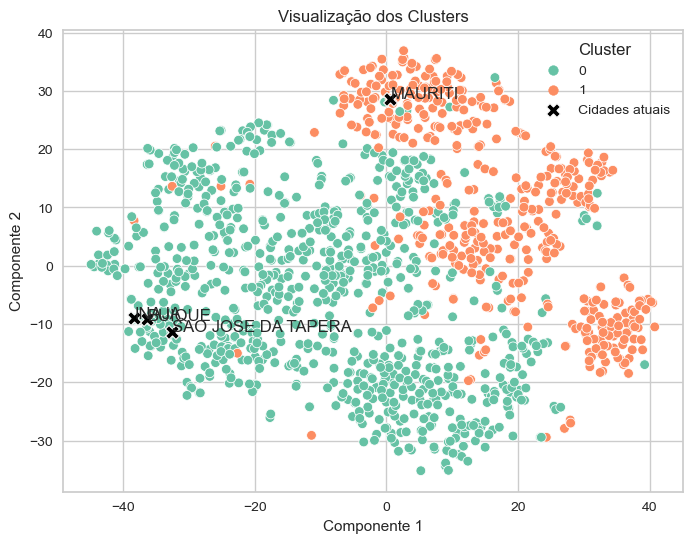

In [9]:
hclustering = AgglomerativeClustering(n_clusters=2)
h_clusters = hclustering.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, h_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, h_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, h_clusters),4))
plot(df, df_components, h_clusters)

### 3.3.2) K-Means

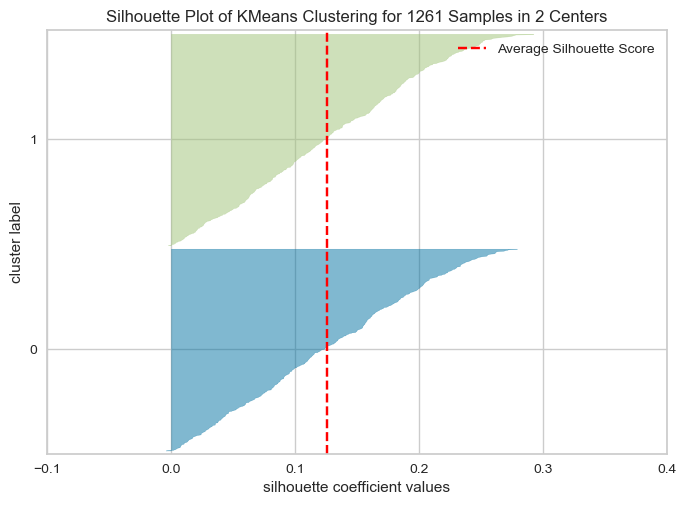

In [31]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reducted)
    score = silhouette_score(df_reducted, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
plt.show()

Silhouette Score:  0.1256
Davies-Bouldin Score:  2.3658
Calinski-Harabasz Index:  205.6565


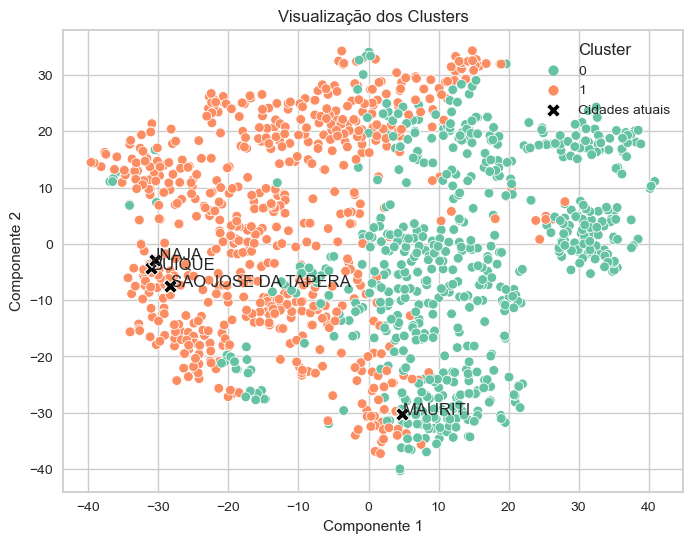

In [32]:
kmeans = KMeans(2, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção das melhores features

In [33]:
X = df[columns]
y = k_clusters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
boruta = BorutaPy(rf_model, n_estimators='auto', verbose=False, random_state=42)
boruta.fit(X_train.values, y_train)
mask_columns_selected = boruta.support_.tolist()
df_pp = X.iloc[:, mask_columns_selected]
columns_selected = df_pp.columns
columns_selected

Index(['DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI', 'IDEB_AF', 'DOCSUP_EF_PUB',
       'DOCSUP_EM_PUB', 'TXNASC7C', 'PDEFAGUA', 'PDEFESGOTO', 'PIND_POS',
       'PMATPUB_EF', 'AGUA_SOLO', 'IDHM', 'T_BANAGUA', 'T_DENS', 'T_LUZ',
       'AGUA_ESGOTO', 'PIND', 'PINDCRI', 'I_FREQ_PROP', 'T_FBSUPER',
       'T_ATRASO_1_BASICO', 'T_ATRASO_1_FUND', 'T_ATRASO_1_MED',
       'T_ATRASO_2_BASICO', 'T_ATRASO_2_FUND', 'T_ATRASO_2_MED',
       'T_ANALF11A14', 'T_ANALF15A17', 'T_ANALF15M', 'T_ANALF18A24',
       'T_ANALF18M', 'T_ANALF25A29', 'T_ANALF25M', 'RDPC', 'TOT_ESC_POR_POP'],
      dtype='object')

## 3.5) Pré-processamento

In [34]:
df_best_features = df[columns_selected].copy()
df_scaled = scaler.fit_transform(df_best_features)

## 3.6) Nova aplicação do PCA

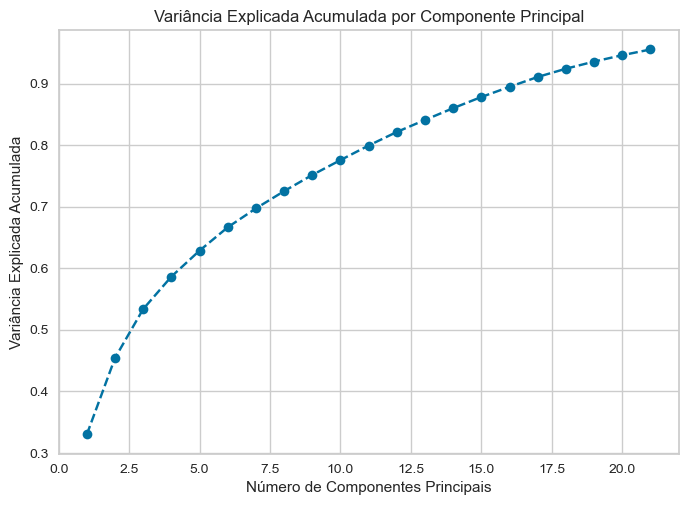

In [35]:
df_reducted = pca.fit_transform(df_scaled)

variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.6) Nova análise de cluster

In [36]:
df_components = tsne.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

### 3.6.1) Hierachical Clustering

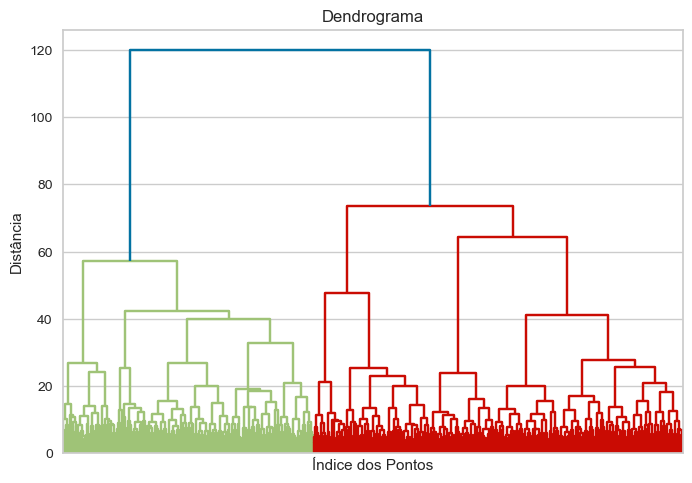

In [16]:
linkage_matrix = linkage(df_reducted, method='ward')

plt.figure()
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xticks([])
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
plt.show()

Silhouette Score:  0.1436
Davies-Bouldin Score:  2.106
Calinski-Harabasz Index:  259.6931


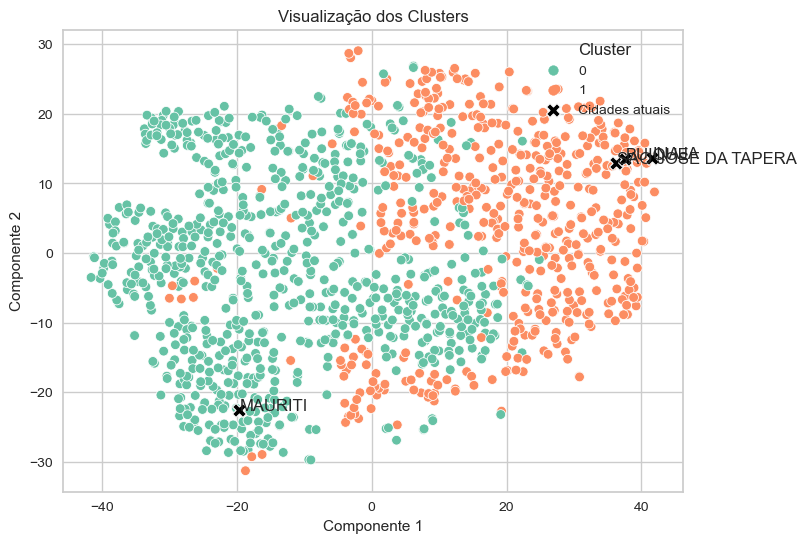

In [17]:
hclustering = AgglomerativeClustering(n_clusters=2)
h_clusters = hclustering.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, h_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, h_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, h_clusters),4))
plot(df, df_components, h_clusters)

### 3.6.2) K-Means

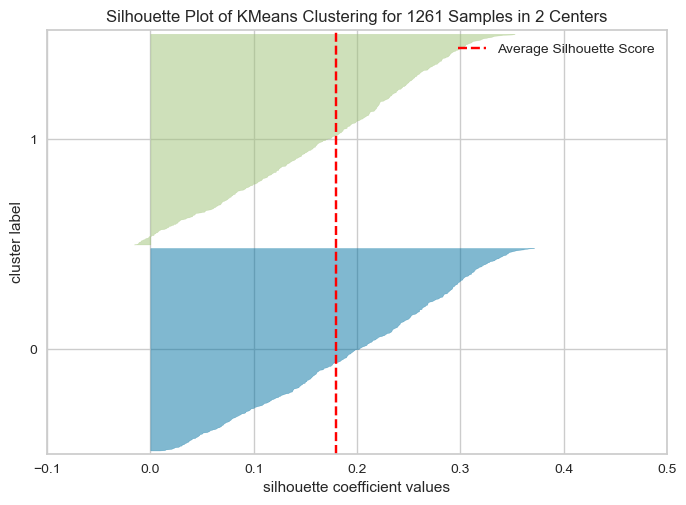

In [37]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reducted)
    score = silhouette_score(df_reducted, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
plt.show()

Silhouette Score:  0.1794
Davies-Bouldin Score:  1.8441
Calinski-Harabasz Index:  348.581


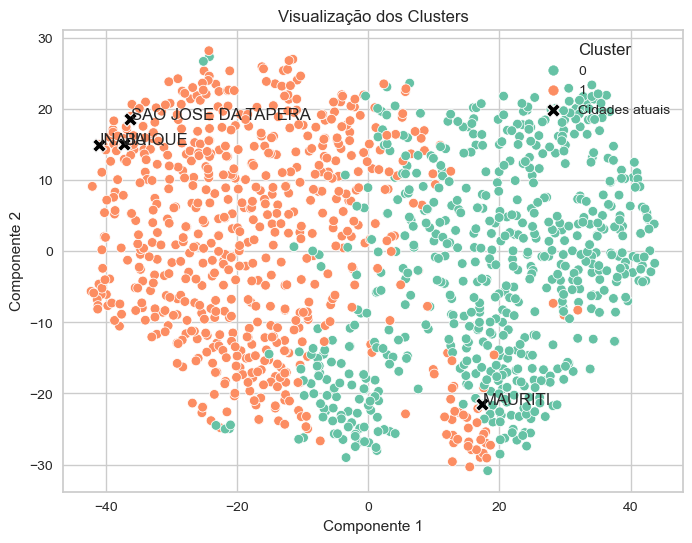

In [38]:
kmeans = KMeans(2, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção dos municípios com maior potencial

In [ ]:
df['CLUSTER'] = k_clusters
df.to_csv('../Dados/Tabela_final/municipios_clusters.csv')

### 3.4.1) Interpretação dos clusters

In [3]:
df = pd.read_csv('../Dados/Tabela_final/municipios_clusters.csv')
df[
    [
        'CLUSTER',
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND'
    ]
].groupby('CLUSTER').mean()

,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND
CLUSTER,,,,,,,,
0,0.619317,29691.120065,151382.666343,310.601990,24.253754,0.651353,7.795712,17.495583
1,0.564936,14339.059720,119282.540591,236.359876,31.351664,0.571764,7.444121,27.082924


In [4]:
df['CLUSTER'].value_counts()

1    643
0    618
Name: CLUSTER, dtype: int64

### 3.4.1) Interpretação dos municípios atuais

In [40]:
actual_cities = df[
    [
        'NOME', 
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'CLUSTER'
    ]
].loc[df['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA'])]

actual_cities

,NOME,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,CLUSTER
34,SAO JOSE DA TAPERA,0.527,32258.8,225558.2,188.84,37.04,0.536,4.33,39.70,1
418,MAURITI,0.605,46103.4,207315.4,236.11,29.51,0.632,8.31,29.78,0
796,BUIQUE,0.527,56502.4,234399.4,176.76,40.18,0.524,7.25,38.73,1
827,INAJA,0.523,21917.0,89734.8,182.73,35.98,0.471,7.35,41.19,1


### 3.4.1) Seleção dos municipios de maior potencial

In [41]:
potential_muns = df.copy()

potential_muns = potential_muns[
    [
        'IBGE7',
        'NOME', 
        'UF',
        'IDHM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'IDEB_AI',
        'IDEB_AF'
    ]
].loc[
    (potential_muns['CLUSTER'] == 1)&
    (potential_muns['POP_TOT'] >= 21917)&
    (potential_muns['POP_TOT_30KM'] >= 89734)&
    ~(potential_muns['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA']))
].sort_values(by='IDHM').reset_index().drop(columns='index')

potential_muns

,IBGE7,NOME,UF,IDHM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,IDEB_AI,IDEB_AF
0,2916500,ITAPICURU,BA,0.486,185.70,38.52,0.462,9.86,31.44,3.912,2.784
1,2705002,MATA GRANDE,AL,0.504,186.87,38.79,0.499,1.57,41.39,4.152,3.260
2,2921500,MONTE SANTO,BA,0.506,197.43,35.57,0.494,4.55,35.11,3.796,3.036
3,2607505,ITAIBA,PE,0.510,218.32,39.73,0.497,4.11,27.48,4.104,3.268
4,2615805,TUPANATINGA,PE,0.519,172.52,38.41,0.513,5.31,45.08,5.200,3.564
...,...,...,...,...,...,...,...,...,...,...,...
72,2904100,BOQUIRA,BA,0.603,266.71,25.81,0.607,10.26,27.30,4.844,4.100
73,2300754,AMONTADA,CE,0.606,182.47,25.67,0.710,6.89,37.41,5.124,4.312
74,2305407,ICO,CE,0.606,274.01,32.83,0.649,5.53,24.65,4.484,3.844
75,2407807,MONTE ALEGRE,RN,0.609,292.15,28.92,0.623,11.57,15.17,3.948,3.136


### 3.4.1) Identificação do município mais prioritário

In [42]:
scaler = MinMaxScaler()
best_mun = potential_muns.copy()
for column in ['IDHM','RDPC','I_FREQ_PROP','IDEB_AI','IDEB_AF']:
    best_mun[column] = 1/best_mun[column]
num_metrics = ['IDHM','RDPC', 'T_ANALF15M', 'I_FREQ_PROP', 'T_DES18M','PIND','IDEB_AI','IDEB_AF']
best_mun[num_metrics] = scaler.fit_transform(best_mun[num_metrics])
best_mun['SCORE'] = best_mun['IDHM'] +best_mun['RDPC'] +best_mun['T_ANALF15M'] +best_mun['I_FREQ_PROP'] + best_mun['T_DES18M'] + best_mun['PIND']+ best_mun['IDEB_AI']+ best_mun['IDEB_AF']
best_mun['SCORE'] = best_mun['SCORE']
best_mun[num_metrics] = best_mun[num_metrics].rank(ascending=False)
best_mun.sort_values(by='SCORE', ascending= False).head(10).reset_index().drop(columns='index')

,IBGE7,NOME,UF,IDHM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,IDEB_AI,IDEB_AF,SCORE
0,2916500,ITAPICURU,BA,1.0,9.0,8.0,1.0,9.0,19.0,14.0,1.0,6.844137
1,2709202,TRAIPU,AL,11.0,6.0,1.0,17.0,75.0,1.0,19.0,23.5,5.851645
2,2100907,ARAIOSES,MA,6.0,3.0,22.0,20.5,28.0,7.0,10.5,33.0,5.732783
3,2805406,POCO REDONDO,SE,10.0,13.0,15.0,7.0,44.0,12.0,1.5,20.5,5.721819
4,2921500,MONTE SANTO,BA,3.0,11.0,16.0,8.0,70.0,13.0,8.0,8.0,5.691649
5,2702900,GIRAU DO PONCIANO,AL,13.0,5.0,13.0,18.5,21.0,8.0,22.0,44.0,5.554645
6,2705002,MATA GRANDE,AL,2.0,10.0,5.0,12.5,77.0,6.0,37.0,27.5,5.463152
7,2902104,ARACI,BA,12.0,17.0,19.0,2.0,48.0,18.0,1.5,16.0,5.461892
8,2615805,TUPANATINGA,PE,5.0,1.0,9.0,14.0,60.0,2.0,72.0,45.0,5.255100
9,2702355,CRAIBAS,AL,8.0,12.0,4.0,39.0,76.0,22.0,25.0,2.0,5.102217
